# 数据清洗

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import numpy as np
from tqdm import tqdm
import math
import random
import json
import matplotlib.pyplot as plt
import cv2
import os
%matplotlib inline

/home/wson/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 筛选top_n分类中没有猫狗的图像

In [2]:
dog_labels = [
 'n02085620','n02085782','n02085936','n02086079','n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364','n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721','n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339','n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258','n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437','n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105','n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236','n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177','n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251','n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550','n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089','n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185','n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889','n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712','n02113799','n02113978']

cat_labels = [
'n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

In [3]:
def model_predict(MODEL, input_size, pre_process_func, decode_func, data_dir, data_size=None, top_n=40):
    model = MODEL(weights='imagenet')
    
    file_list = os.listdir(data_dir)
    if data_size and data_size < len(file_list):
        idxs = random.sample(range(len(file_list)), data_size)
        file_list = [file_list[i] for i in idxs]
    
    out_liers = []
    for file in tqdm(file_list):
        img = load_img(data_dir + '/' + file, target_size=input_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = pre_process_func(x)
        pred = model.predict(x)
        top_n_classes = decode_func(pred, top=top_n)[0]
        
        if data_dir[-3:] == 'dog':
            cls_labels = dog_labels
        else:
            cls_labels = cat_labels
        
        flag = False
        for cls_tuple in top_n_classes:
            if cls_tuple[0] in cls_labels:
                flag = True
                break
        if not flag:
            out_liers.append(file)
    
    return out_liers


In [4]:
def plot_img_list(data_dir, img_list, fig_w=5):
    img_num = len(img_list)
    fig_h = math.ceil(img_num/fig_w)
    plt.figure(figsize=(18, 5*fig_h))
    for i in range(img_num):
        plt.subplot(fig_h, fig_w, i+1)
        plt.gca().set_title(img_list[i])
        plt.imshow(load_img(data_dir + '/' + img_list[i]))

    plt.show()
    

In [27]:
dog_outliers = model_predict(InceptionResNetV2, (229, 229), inception_resnet_v2.preprocess_input, inception_resnet_v2.decode_predictions, "train/dog", top_n=60)
cat_outliers = model_predict(InceptionResNetV2, (229, 229), inception_resnet_v2.preprocess_input, inception_resnet_v2.decode_predictions, "train/cat", top_n=120)

100%|██████████| 12500/12500 [11:37<00:00, 17.93it/s]


In [28]:
print(len(dog_outliers))
print(len(cat_outliers))

20
24


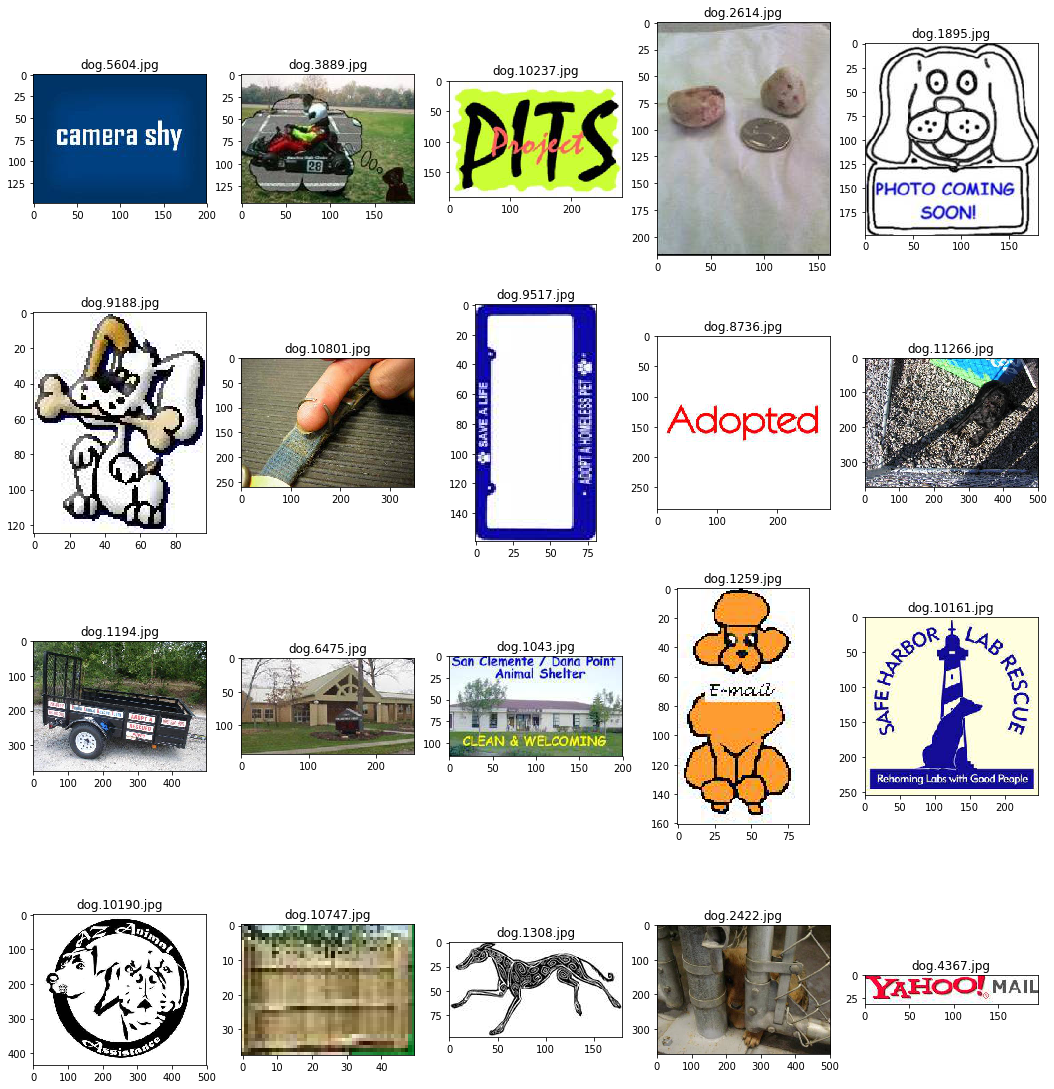

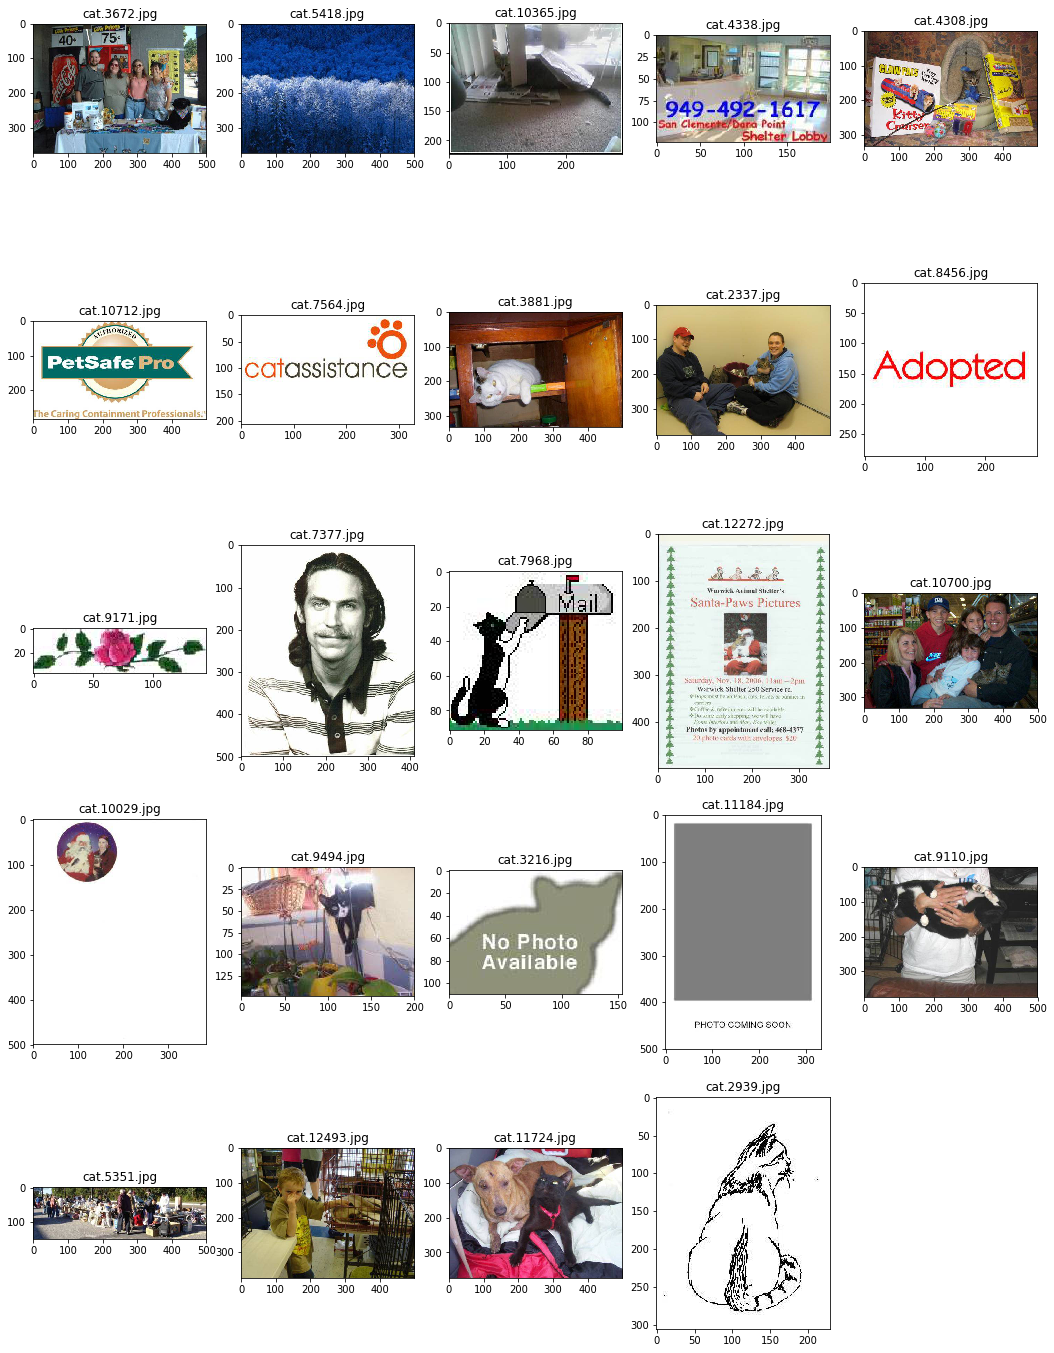

In [29]:
plot_img_list("train/dog", dog_outliers)
plot_img_list("train/cat", cat_outliers)

In [30]:
out_file = "outliers_InceptionResNetV2.json"
with open(out_file, 'w') as f:
    json.dump({'dog':dog_outliers, 'cat':cat_outliers}, f)
    

### 处理异常值

In [31]:
def read_data(filename):
    with open(filename, 'r') as f:
        data_dict = json.load(f)
    dog_outliers = data_dict['dog']
    cat_outliers = data_dict['cat']
    
    return dog_outliers + cat_outliers


In [32]:
total_outliers = read_data("outliers_InceptionResNetV2.json")
total_outliers = total_outliers + read_data("outliers_Xception.json")
total_outliers = total_outliers + read_data("outliers_InceptionV3.json")
total_outliers = list(set(total_outliers))
print(len(total_outliers))
# plot_img_list("../dog_vs_cat_data/train", total_outliers)

out_file = "total_outliers.json"
with open(out_file, 'w') as f:
    json.dump(total_outliers, f)
    

83


### 人工筛选 裁剪填充

In [10]:
def crop_img(filename, start_h, end_h, start_w, end_w, pad_h=0, pad_w=0):
    img = cv2.imread('../dog_vs_cat_data/train/' + filename)
    img = img[start_h:end_h, start_w:end_w]
    if pad_h or pad_w:
        img = cv2.copyMakeBorder(img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    plt.imshow(img[:,:,::-1])
    
    if not os.path.exists('crop_data'):
        os.mkdir('crop_data')
    if os.path.exists('crop_data/' + filename):
        os.remove('crop_data/' + filename)
    cv2.imwrite('crop_data/' + filename, img)


(374, 500, 3)


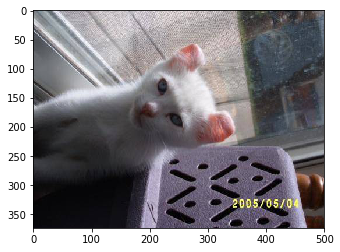

In [47]:
filename = 'cat.519.jpg'

img = cv2.imread('../dog_vs_cat_data/train/' + filename)
print(img.shape)
plt.imshow(img[:,:,::-1])
del img
del filename

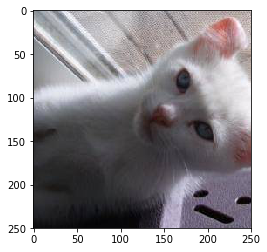

In [11]:
crop_img('cat.519.jpg', 50, 300, 50, 300)

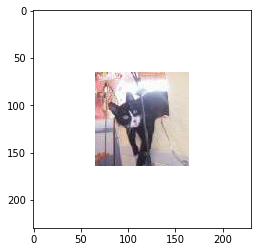

In [12]:
crop_img('cat.9494.jpg', 0, 100, 75, 175, 65, 65)

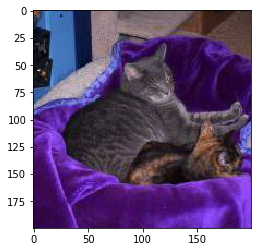

In [13]:
crop_img('cat.7111.jpg', 100, 300, 150, 350)

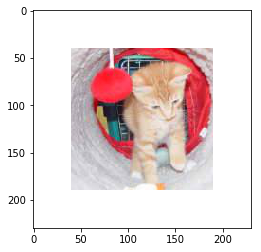

In [14]:
crop_img('cat.10209.jpg', 50, 200, 50, 200, 40, 40)

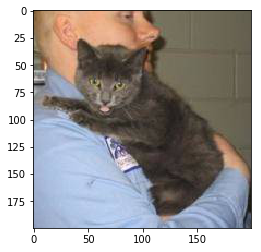

In [15]:
crop_img('cat.9391.jpg', 100, 300, 150, 350)

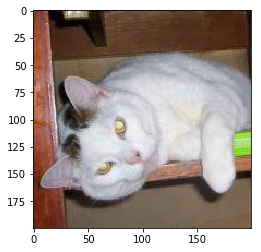

In [16]:
crop_img('cat.3881.jpg', 100, 300, 50, 250)

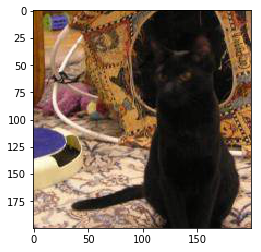

In [17]:
crop_img('cat.9695.jpg', 100, 300, 100, 300)

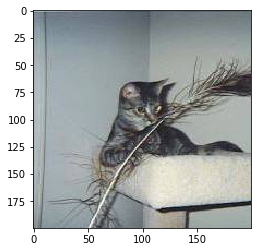

In [18]:
crop_img('cat.9983.jpg', 0, 200, 100, 300)

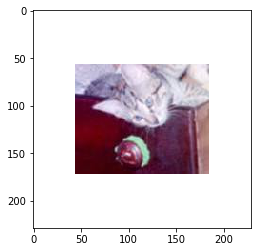

In [19]:
crop_img('cat.4842.jpg', 0, 115, 0, 141, 57, 44)

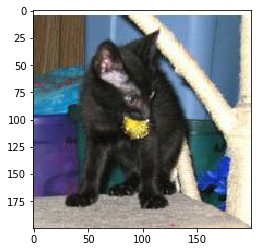

In [20]:
crop_img('cat.23.jpg', 0, 200, 100, 300)

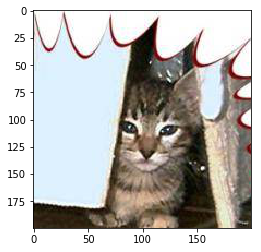

In [21]:
crop_img('cat.6817.jpg', 0, 200, 250, 450)

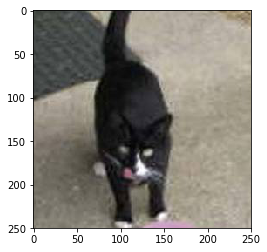

In [22]:
crop_img('cat.11823.jpg', 50, 300, 0, 250)